<a href="https://colab.research.google.com/github/JamesPeralta/Gymnos/blob/master/Neural-Network/Iteration2/Model_Training_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gymnos Iteration 2
## Gymnos iteration 2 will use a single stream 2D convolutional neural network. For each video we will be passing in only one frame and the AIs prediction will be based on the single frame.



In [0]:
# You can list all of the hardware device running on your instance
from tensorflow.python.client import device_lib

local_devices = device_lib.list_local_devices()

for device in local_devices:
  print("_______________________________________\n" + str(device))

---
## Mount drive and download libraries from Github

In [1]:
from google.colab import drive
import os
import csv
import importlib

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Retrieve the Data Generator Library
!curl "https://raw.githubusercontent.com/JamesPeralta/Gymnos/master/Neural-Network/Iteration2/GymnoDataGenerator_i2.py?token=AFLRMHLKFZZ6UI7HZLFFNBK42D3TC" >> GymnosDataGenerator_i2.py
# Retrieve the Helper Functions Library
!curl "https://raw.githubusercontent.com/JamesPeralta/Gymnos/master/Neural-Network/Iteration2/HelperFunctions_i2.py?token=AFLRMHP6ZJFKGGWHSWBL33C42D3WM" >> HelperFunctions_i2.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3865  100  3865    0     0  19228      0 --:--:-- --:--:-- --:--:-- 19228
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6054  100  6054    0     0  44844      0 --:--:-- --:--:-- --:--:-- 44844


---
## Imports

In [3]:
import GymnosDataGenerator_i2 as gen
import HelperFunctions_i2 as helper

Using TensorFlow backend.


---
## Create a labels and partitions CSV


In [0]:
csv_location = "/content/drive/My Drive/GYMNOS/Video Dataset/"
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"
partitions_location = "/content/drive/My Drive/GYMNOS/Video Dataset/partitions.csv"
squats_location = "/content/drive/My Drive/GYMNOS/Video Dataset/Squats/FaceView/"
overhead_location = "/content/drive/My Drive/GYMNOS/Video Dataset/Overhead Press/FaceView/"
squats_label = 0
overhead_label = 1

In [0]:
helper.init_labels_csv(labels_location)

In [0]:
# Label the squat dataset
helper.append_to_labels_csv(labels_location, squats_location, squats_label)

# Label the overhead press dataset
helper.append_to_labels_csv(labels_location, overhead_location, overhead_label)

In [0]:
helper.generate_partitions_csv(partitions_location, labels_location)

---
## Read in the labels and partitions CSVs


In [0]:
partition_location = "/content/drive/My Drive/GYMNOS/Video Dataset/partitions.csv"
labels_location = "/content/drive/My Drive/GYMNOS/Video Dataset/labels.csv"

partition = helper.read_partition_csv(partition_location)
labels = helper.read_labels_csv(labels_location)

In [36]:
print(len(partition["train"]))
print(len(partition["validation"]))
print(len(partition["test"]))

53
15
8


In [0]:
# Expand the train partition by 20
new_train = []
for i in range(20):
  for train in partition["train"]:
    new_train.append(train)
    
partition["train"] = new_train

--- 
## Initialize the DataGenerator

In [0]:
import matplotlib.pyplot as plt

In [0]:
train_params = {'frames_per_video': 10,
                'frame_dim': (256, 256),
                'batch_size': 5,
                'n_classes': 2,
                'shuffle': True}

train_generator = gen.DataGenerator(partition["train"], labels, **train_params)

In [0]:
vid_frames, vid_labels = train_generator.__getitem__(0)

In [41]:
vid_frames.shape

(5, 10, 256, 256, 3)

In [43]:
print(vid_labels)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

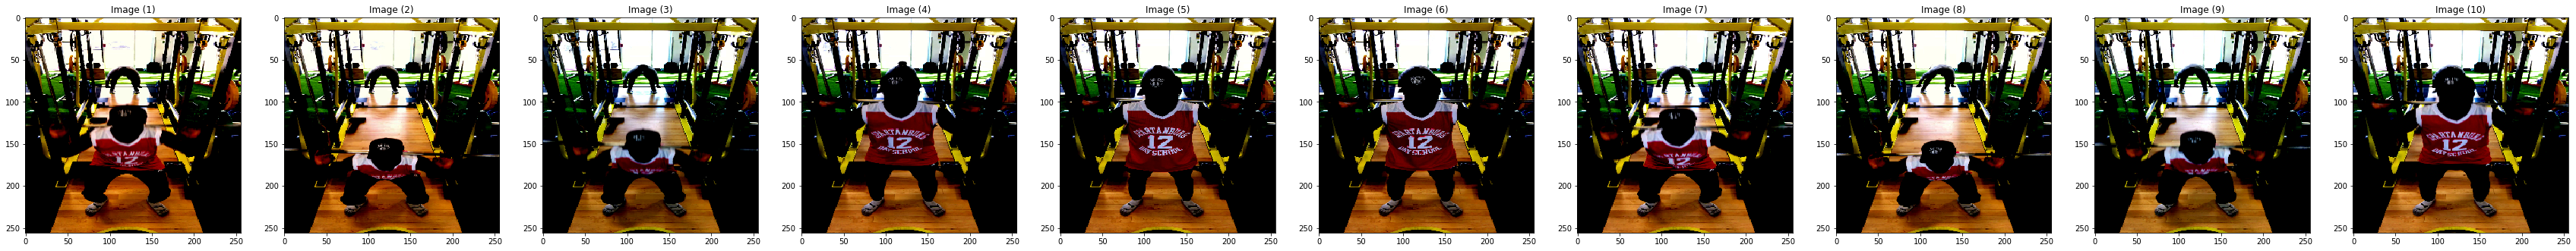

In [46]:
helper.show_images(vid_frames[2])

In [0]:
vid_frames.shape

---
## Add TPU Support

In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.train import RMSPropOptimizer
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import load_model

---
## Create the model


In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))    # include_top=False to remove the top layer

# Freeze all of the layers from the Conv base because we are performing transfer learning on
for layer in base_model.layers:
  layer.trainable = False
  
for layer in base_model.layers:
  print(layer, layer.trainable)

In [0]:
model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.summary()

In [0]:
# Convert model to TPU version
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
            model,
            strategy=tf.contrib.tpu.TPUDistributionStrategy(
            tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

In [0]:
tpu_model.compile(optimizer=RMSPropOptimizer(learning_rate=1e-3), 
              loss=binary_crossentropy,
              metrics=['acc'])

In [0]:
train_generator.__len__()

In [0]:
history = tpu_model.fit_generator(train_generator,
                                  steps_per_epoch=train_generator.__len__(),
                                  epochs=30,
                                  validation_data=validation_generator,
                                  validation_steps=validation_generator.__len__(),
                                  verbose=1)

In [0]:
iteration_1_location = "/content/drive/My Drive/GYMNOS/Software Development/Implementation Details/Gymnos_i1/gymnos_i1_GPU.h5"

In [0]:
# Save all of your hard work
model.save(iteration_1_location)

---
## Evaluating the Model
Now that the Model has it's weights initialized, let see how it performs on the test set.

In [0]:
trained_model = load_model(iteration_1_location)

In [0]:
# Parameters
params = {'data_location': "/content/drive/My Drive/GYMNOS/Video Dataset/Frames/",
          'dim': (224, 224, 3),
          'batch_size': 64,
          'n_classes': 2,
          'shuffle': True}

test_generator = gen.DataGenerator(partition["test"], labels, **params)

In [0]:
images, pred_class = test_generator.__getitem__(0)

In [0]:
helper.show_images(images)

In [0]:
model_predictions = trained_model.predict_classes(images)

In [0]:
for index, number in enumerate(model_predictions):
  if number == 0:
    print("Image("+ str(index + 1) + ") is a squat")
  else:
    print("Image("+ str(index + 1) + ") is a overheadpress")